# Visible Eye Labels
### Constucting Custom "Visible Eye" Labels for the GOES imagery using quadrantized radial profiles. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from tqdm import tqdm

In [2]:
tc_data = pd.read_csv('/VOLUMES/SEAGATE/capsnet/tc_data_clean.csv', parse_dates=['date'], infer_datetime_format=True)
ids = pd.unique(tc_data.ID)

In [27]:
storm.radius.values[:30]

array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110.,
       115., 120., 125., 130., 135., 140., 145., 150.])

In [28]:
storm.radius.values

array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105., 110.,
       115., 120., 125., 130., 135., 140., 145., 150., 155., 160., 165.,
       170., 175., 180., 185., 190., 195., 200., 205., 210., 215., 220.,
       225., 230., 235., 240., 245., 250., 255., 260., 265., 270., 275.,
       280., 285., 290., 295., 300., 305., 310., 315., 320., 325., 330.,
       335., 340., 345., 350., 355., 360., 365., 370., 375., 380., 385.,
       390., 395., 400.])

In [75]:
# Get Mean and Std of sectors

ORB_DIR = '/VOLUMES/SEAGATE/ORB_quadrants/'

sectors_tot = []

for id in tqdm(ids, desc = 'Storm IDs'):
    storm_data = tc_data[tc_data.ID == id]
    storm_dates = storm_data.date.to_numpy()

    storm = xr.open_dataset(ORB_DIR + id + '.nc', engine = 'netcdf4')
    storm['time'] = pd.to_datetime(storm.time.values).round('min')

    sectors = []
    for t in storm_dates:
        try:
            sectors.append(np.array([storm.sel(time = t, sector = jj).profile.values for jj in [1, 2, 3, 4]]))
            
        except:
            print(f'Missing {id} at {t}')

    sectors_tot.extend(sectors)

Storm IDs: 100%|██████████| 333/333 [04:43<00:00,  1.18it/s]


In [77]:
sectors = np.array(sectors_tot)
sectors.shape

(71595, 4, 80)

In [82]:
sectors_mean = np.nanmean(sectors, axis = (0, 1))
sectors_std = np.nanstd(sectors, axis = (0, 1))

In [85]:
sectors_mean

array([-36.54386287, -37.07733096, -37.87874674, -38.74417673,
       -39.54787285, -40.12285752, -40.51544879, -40.71089092,
       -40.75010889, -40.66534664, -40.44363382, -40.16234853,
       -39.79094852, -39.36955313, -38.89041686, -38.39807903,
       -37.85965912, -37.31501468, -36.75537268, -36.17257801,
       -35.58759073, -34.98655889, -34.37753925, -33.79043649,
       -33.16635813, -32.53805807, -31.91464567, -31.3015869 ,
       -30.67529209, -30.06432317, -29.43255535, -28.80610744,
       -28.18915763, -27.56819188, -26.94242271, -26.33208832,
       -25.73999943, -25.12498782, -24.5423112 , -23.92579696,
       -23.3357953 , -22.74796976, -22.17706566, -21.58272161,
       -21.02030574, -20.45084699, -19.87740583, -19.32860484,
       -18.75517164, -18.21088355, -17.66202827, -17.12414153,
       -16.60845046, -16.07944536, -15.56023448, -15.04672301,
       -14.56827268, -14.05179756, -13.57800454, -13.08277612,
       -12.60024473, -12.14427851, -11.67414422, -11.20

In [87]:
ORB_DIR = '/VOLUMES/SEAGATE/ORB_quadrants/'

for id in tqdm(ids, desc = 'Storm IDs'):
    storm_data = tc_data[tc_data.ID == id]
    storm_dates = storm_data.date.to_numpy()

    storm = xr.open_dataset(ORB_DIR + id + '.nc', engine = 'netcdf4')
    storm['time'] = pd.to_datetime(storm.time.values).round('min')

    max_diffs = []
    asyms = []
    missing_t = []
    for t in storm_dates:
        try:
            sectors = np.array([storm.sel(time = t, sector = jj).profile.values for jj in [1, 2, 3, 4]])
            diffs = [sectors[jj, 0] - np.min(sectors[jj, :30]) for jj in range(4)]
            diff = np.max(diffs)
            max_diffs.append(diff)

            sectors_standard = (sectors - sectors_mean)/sectors_std
            asym = np.mean(np.max(sectors_standard[:, :60], axis = 0) - np.min(sectors_standard[:, :60], axis = 0))
            asyms.append(asym)

        except:
            max_diffs.append(0)
            asyms.append(999)
            missing_t.append(t)
            print(f'Missing {id} at {t}')

    max_diffs = np.array(max_diffs)
    asyms = np.array(asyms)

    tc_data.loc[tc_data.ID == id, 'eye_diff'] = max_diffs 
    tc_data.loc[tc_data.ID == id, 'asym'] = asyms

Storm IDs: 100%|██████████| 333/333 [04:52<00:00,  1.14it/s]


<AxesSubplot:>

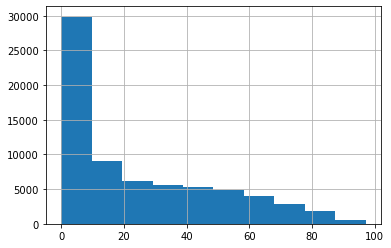

In [88]:
tc_data.eye_diff.hist()

<AxesSubplot:>

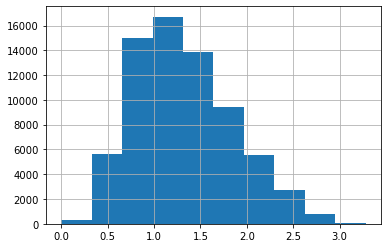

In [89]:
tc_data.asym.hist()

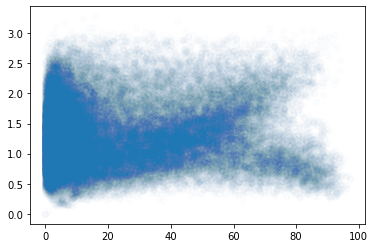

In [90]:
plt.scatter(tc_data.eye_diff, tc_data.asym, alpha = 0.01)

In [9]:
imgs = np.load('/VOLUMES/SEAGATE/capsnet/satellite_images_clean.npy', mmap_mode = 'r')

In [124]:
EYE_THRESH = 60
ASYM_THRESH = 1.4
WIND_THRESH = 60
eye_idxs = tc_data[(tc_data.eye_diff > EYE_THRESH) & (tc_data.wind > WIND_THRESH) & (tc_data.asym < ASYM_THRESH)].index.to_numpy()
no_eye_idxs = tc_data[tc_data.eye == 0].index.to_numpy()
print(f'Eye: {len(eye_idxs)}')
print(f'No Eye: {len(no_eye_idxs)}')

Eye: 4351
No Eye: 24467


IDEA:
* Use to above cutoffs to isolate the lower right corner of the scatter plot. These are definite "eye visible" points.
* Use the eye = 0 label for no-eye class
* Do flips and mirrors for the eye classification to increase class size and see if it helps
* Then go back and classify other images that are unknown (other halfish of the dataset)

In [123]:
tc_data

ID                date  time_idx       wind  eye_diam     rmw  \
0      AL032000 2000-08-04 06:00:00        24  35.000000     -99.0   55.56   
1      AL032000 2000-08-04 06:30:00        25  35.000000       NaN     NaN   
2      AL032000 2000-08-04 07:00:00        26  35.000000       NaN     NaN   
3      AL032000 2000-08-04 07:30:00        27  35.000000       NaN     NaN   
4      AL032000 2000-08-04 08:00:00        28  35.000000       NaN     NaN   
...         ...                 ...       ...        ...       ...     ...   
71590  AL312020 2020-11-18 04:00:00       272  36.666667       NaN     NaN   
71591  AL312020 2020-11-18 04:30:00       273  36.250000       NaN     NaN   
71592  AL312020 2020-11-18 05:00:00       274  35.833333       NaN     NaN   
71593  AL312020 2020-11-18 05:30:00       275  35.416667       NaN     NaN   
71594  AL312020 2020-11-18 06:00:00       276  35.000000     -99.0  259.28   

        atcf   lat   lon  pressure_min  ...  eye synoptic  eye_10  eye_20  \
0      False  12.0  22.3        1004.0  ...    0        1       0       0   
1        NaN   NaN   NaN           NaN  ...    0        0       0       0   
2        NaN   NaN   NaN           NaN  ...    0        0       0       0   
3        NaN   NaN   NaN           NaN  ...  -99        0     -99     -99   
4        NaN   NaN   NaN           NaN  ...  -99        0     -99     -99   
...      ...   ...   ...           ...  ...  ...      ...     ...     ...   
71590    NaN   NaN   NaN           NaN  ...  -99        0     -99     -99   
71591    NaN   NaN   NaN           NaN  ...  -99        0     -99     -99   
71592    NaN   NaN   NaN           NaN  ...    0        0       0       0   
71593    NaN   NaN   NaN           NaN  ...    0        0       0       0   
71594  False  13.8  87.8        1005.0  ...    0        1       0       0   

       eye_30  category  category_num  nan_frac   eye_diff      asym  
0           0        TS             0  0.000000   4.791668  1.501012  
1           0        TS             0  0.000025   8.733345  1.390985  
2           0        TS             0  0.000000   6.791668  1.329336  
3         -99        TS             0  0.000000  13.375576  1.285350  
4         -99        TS             0  0.000000  26.442848  1.312361  
...       ...       ...           ...       ...        ...       ...  
71590     -99        TS             0  0.000000  16.523813  0.743793  
71591     -99        TS             0  0.000000  19.114288  0.716722  
71592       0        TS             0  0.000000  18.487181  0.714265  
71593       0        TS             0  0.000000  21.982765  0.759467  
71594       0        TS             0  0.000000  24.194447  0.791495  

[71595 rows x 24 columns]

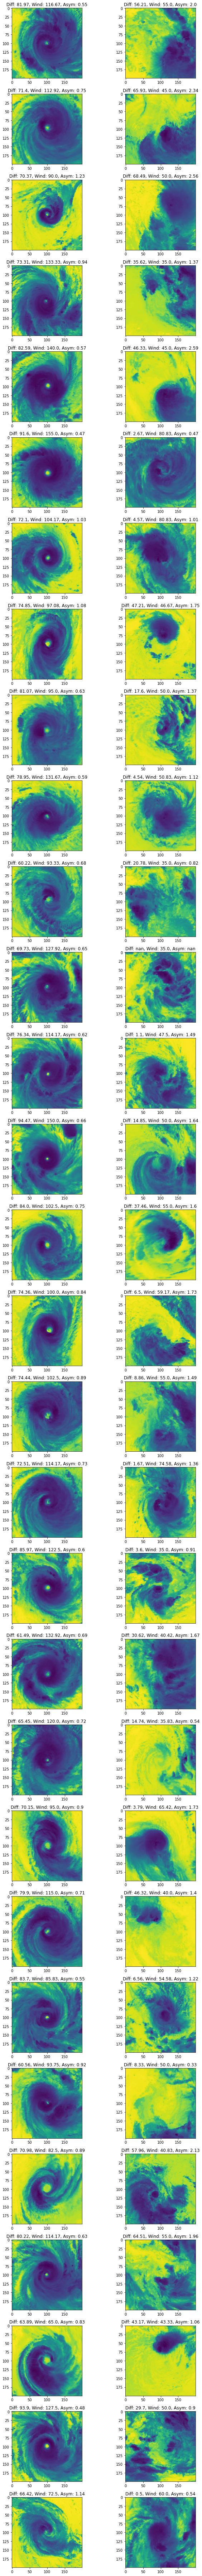

In [126]:
nplot = 30
randseed = 101

fig, axs = plt.subplots(nrows = nplot, ncols = 2, figsize = (10, 100))
np.random.seed(randseed)
indices = [np.random.choice(x, size = nplot, replace = False) for x in [eye_idxs, no_eye_idxs]]

indices = np.array(indices).T

for ii, ind in enumerate(indices):
    for jj, idx in enumerate(ind):
        axs[ii, jj].imshow(imgs[idx])
        diff = tc_data.loc[idx, 'eye_diff']
        asym = tc_data.loc[idx, 'asym']
        wind = tc_data.loc[idx, 'wind']
        axs[ii, jj].set_title(f'Diff: {np.round(diff, 2)}, Wind: {np.round(wind, 2)}, Asym: {np.round(asym, 2)}')
        #axs[ii, jj].scatter(x = [99.5], y = [99.5], color = 'red', marker = '2') # Marker at the center of the image

plt.tight_layout()